# [농업 영상 AI 데이터 활용 아이디어 해커톤 대회](http://k-farmdata.com/hackathon/)
NIA와 경상대에서 주최한 AI 해커톤 대회입니다  
최우수상을 수상하였고 머신러닝과 딥러닝의 차이점에 대해 명확히 알 수 있었습니다

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DongChanKIM2/AI-Data-Hackathon-Competiton/blob/main/**Fruit_ML**.ipynb)

## 구글드라이브에 연결(대용량 데이터라 드라이브가 용이)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

## 라이브러리 생성

In [ ]:
import numpy as np # 수학연산
import cv2 # 이미지처리
import glob # 경로명을 이용해 파일들의 리스트 추출
import zipfile # 알집압축풀기
import os # 현재 위치 찾기, 경로 병합해서 새로운 경로 생성

import matplotlib.pyplot as plt # 시각화
from mpl_toolkits.mplot3d import Axes3D # 3차원

from sklearn.model_selection import train_test_split, cross_val_score # train/test split
from sklearn.utils.multiclass import unique_labels # 중복값 제거해주는 배열
from sklearn import metrics # ytest와 ypred 비교

from sklearn.decomposition import PCA # PCA
from sklearn.preprocessing import StandardScaler # 표준화
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn.svm import SVC # 선형경계 SVM

# 구글드라이브 list 출력
print(os.listdir("/content/drive"))

# opencv parameter 설정
dim = 100

['MyDrive', '.shortcut-targets-by-id', '.file-revisions-by-id', '.Trash']


In [ ]:
# 압축된 데이터가 경로
path_to_zip_file = '/content/drive/MyDrive/data.zip'
# 압축 해제할 경로
directory_to_extract_to = '/content/drive/MyDrive'


with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [ ]:
def getYourFruits(fruits, data_type, print_n=False, k_fold=False):
    images = []
    labels = []
    # Training Data와 Test Data 별도로 생성
    val = ['Training', 'Test']
    # 데이터가 부족할 상황을 대비해서 else: K_FOLD
    if not k_fold:
      path = "/content/drive/MyDrive/" + data_type + "/"
      for i,f in enumerate(fruits):
        p = path + f
        print(p)
        j=0
        for image_path in glob.glob(os.path.join(p, "*.png")):
          image = cv2.imread(image_path, cv2.IMREAD_COLOR)
          image = cv2.resize(image, (dim, dim))
          image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
          images.append(image)
          labels.append(i)
          j+=1
        if(print_n):
          print("There are " , j , " " , data_type.upper(), " images of " , fruits[i].upper())
      images = np.array(images)
      labels = np.array(labels)
      return images, labels
    else:
      for v in val:
        path = "/content/drive/MyDrive/" + v + "/"
        for i,f in enumerate(fruits):
          p = path + f
          print(p)
          j=0
          for image_path in glob.glob(os.path.join(p, "*.png")):
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (dim, dim))
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            images.append(image)
            labels.append(i)
            j+=1
      images = np.array(images)
      labels = np.array(labels)
      return images, labels
    
def getAllFruits():
    fruits = []
    for fruit_path in glob.glob("/content/drive/MyDrive/Training/*"):
      fruit = fruit_path.split("/")[-1]
      fruits.append(fruit)
    return fruits

In [ ]:
# fruits = ['Lapple', 'Mapple'] #Binary classification
dim = 100
fruits = ['Badbooyu', 'Bestbooyu', 'Normalbooyu']
# fruits = getAllFruits()
#Get Images and Labels 
X_t, y_train =  getYourFruits(fruits, 'Training', print_n=True, k_fold=False)
X_test, y_test = getYourFruits(fruits, 'Test', print_n=True, k_fold=False)

print(X_t.shape)

#Get data for k-fold
X,y = getYourFruits(fruits, '', print_n=True, k_fold=True)

print(X.shape)

#Scale Data Images
scaler = StandardScaler()
X_train = scaler.fit_transform([i.flatten() for i in X_t])
X_test = scaler.fit_transform([i.flatten() for i in X_test])
X = scaler.fit_transform([i.flatten() for i in X])

print(X_train.shape)
print(X_test.shape)
print(X.shape)

In [ ]:
def plot_image_grid(images, nb_rows, nb_cols, figsize=(15, 15)):
    assert len(images) == nb_rows*nb_cols, "Number of images should be the same as (nb_rows*nb_cols)"
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize)
    
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].axis('off')
            axs[i, j].imshow(images[n])
            n += 1    

## 이미지 데이터 load 확인

BadMandarine


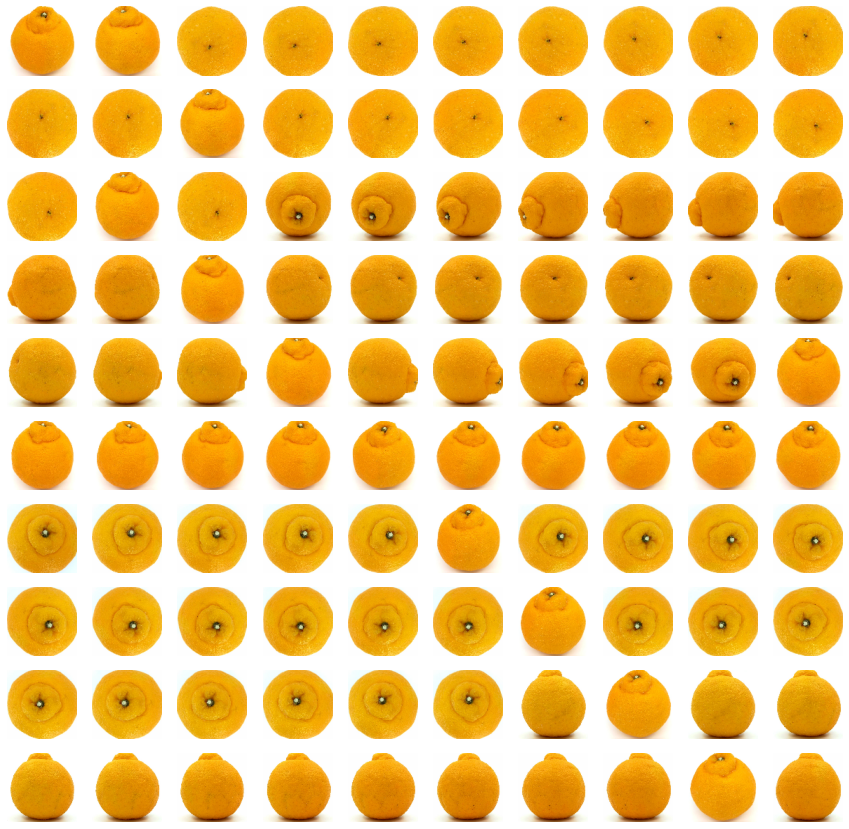

In [ ]:
print(fruits[y_train[0]])
plot_image_grid(X_t[0:100], 10, 10)

BestMandarine


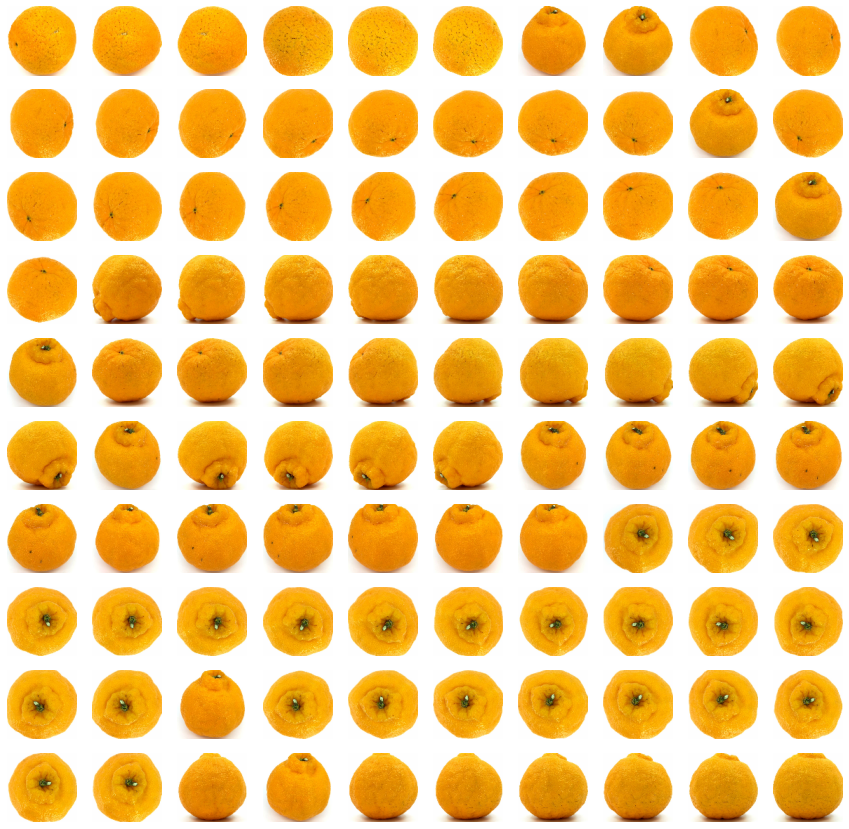

In [ ]:
print(fruits[y_train[3000]])
plot_image_grid(X_t[3000:3100], 10, 10)

NormalMandarine


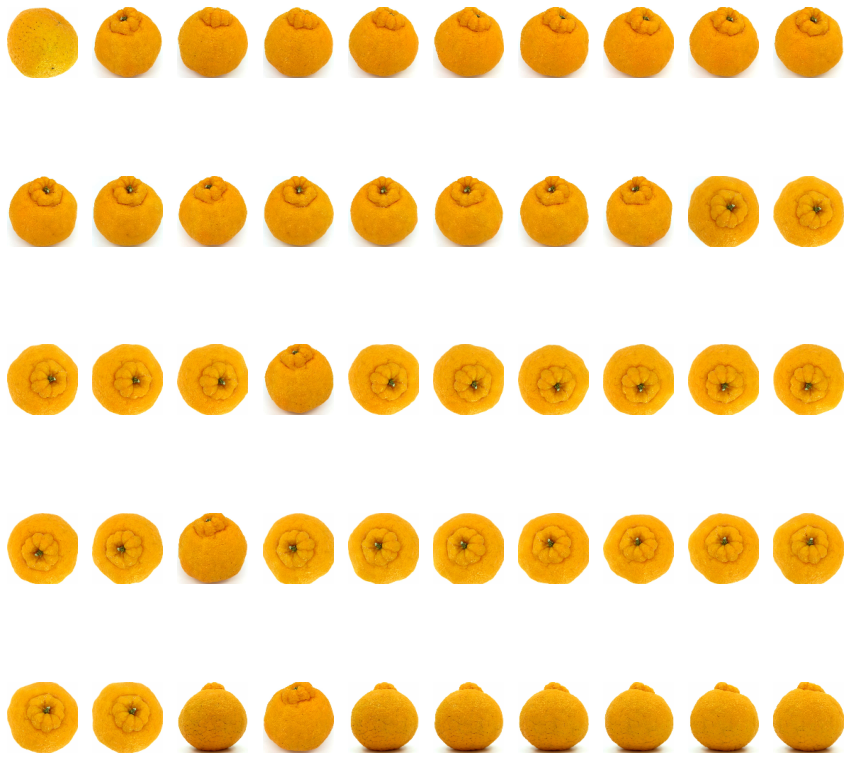

In [ ]:
print(fruits[y_train[3700]])
plot_image_grid(X_t[3700:3750], 5, 10)

In [ ]:
def getClassNumber(y):
    v =[]
    i=0
    count = 0
    for index in y:
        if(index == i):
            count +=1
        else:
            v.append(count)
            count = 1
            i +=1
    v.append(count)        
    return v

def plotPrincipalComponents(X, dim):
    v = getClassNumber(y_train)
    colors = 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'grey', 'orange', 'purple'
    markers = ['o', 'x' , 'v', 'd']
    tot = len(X)
    start = 0 
    if(dim == 2):
        for i,index in enumerate(v):
            end = start + index
            plt.scatter(X[start:end,0],X[start:end,1] , color=colors[i%len(colors)], marker=markers[i%len(markers)], label = fruits[i])
            start = end
        plt.xlabel('PC1')
        plt.ylabel('PC2')
    
    if(dim == 3):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        for i,index in enumerate(v):
            end = start + index
            ax.scatter(X[start:end,0], X[start:end,1], X[start:end,2], color=colors[i%len(colors)], marker=markers[i%len(markers)], label = fruits[i])
            start = end
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')


    plt.legend(loc='lower left')
    plt.xticks()
    plt.yticks()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=fruits, yticklabels=fruits,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return cm,ax

## PCA 상품분류

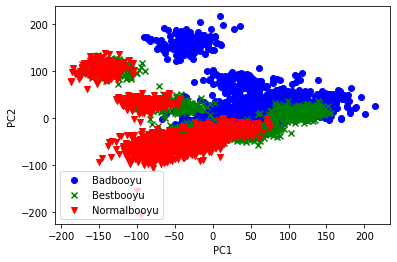

In [ ]:
pca = PCA(n_components=2)
dataIn2D = pca.fit_transform(X_train)
plotPrincipalComponents(dataIn2D, 2)

## Decision Tree

Accuracy with Decision Tree: 88.33%


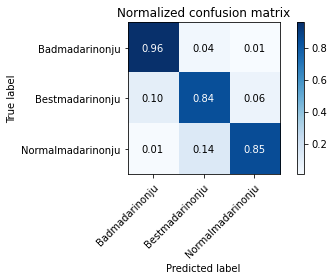

ValueError: ignored

In [ ]:
# binary classification에서 더 자세한 정보를 보고 싶을 때 사용
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

tree = DecisionTreeClassifier()
tree = tree.fit(X_train,y_train)
y_pred = tree.predict(X_test)

#Evaluation
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with Decision Tree: {0:.2f}%".format(precision))
cm , _ = plot_confusion_matrix(y_test, y_pred, classes=y_train, normalize=True, title='Normalized confusion matrix')
plt.show()

# calculate the FPR and TPR for all thresholds of the classification
probs = tree.predict_proba(X_test)
probs = probs[:, 1]
tree_fpr, tree_tpr, thresholds = metrics.roc_curve(y_test, probs)
tree_auc = metrics.roc_auc_score(y_test, probs)


## 품질분류

In [ ]:
fruits = ['Badbooyu', 'Bestbooyu', 'Normalbooyu']
#fruits = getAllFruits() #Be sure to have enough free memory

#Get Images and Labels
X, y =  getYourFruits(fruits, 'Training')
X_test, y_test = getYourFruits(fruits, 'Test')

#Scale Data Images
scaler = StandardScaler()
X_train = scaler.fit_transform([i.flatten() for i in X])
X_test = scaler.fit_transform([i.flatten() for i in X_test])

print(X_train)

In [ ]:
model = SVC(gamma='auto', kernel='linear')
model.fit(X_train, y) 
y_pred = model.predict(X_test)
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with SVM: {0:.2f}%".format(precision))

#K-NN
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y)
y_pred = model.predict(X_test)
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with K-NN: {0:.2f}%".format(precision))

#DECISION TREE
model = DecisionTreeClassifier()
model.fit(X_train,y)
y_pred = model.predict(X_test)
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with Decision Tree: {0:.2f}%".format(precision))

from lightgbm import LGBMClassifier

#LGBMClassifier
model = LGBMClassifier()
model.fit(X_train,y)
y_pred = model.predict(X_test)
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with LGBM: {0:.2f}%".format(precision))

Accuracy with SVM: 54.44%
Accuracy with K-NN: 84.31%
Accuracy with Decision Tree: 47.58%
Accuracy with LGBM: 56.81%


## 참조
https://www.kaggle.com/moltean/fruits